In [1]:
import warnings
import pyforest as py
import copy
from pathlib import Path

import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting 
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss


%matplotlib inline 
warnings.filterwarnings('ignore')


In [2]:
df_train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'])

df_shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')

df_items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')

df_item_category = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [4]:
df_train['date'] = pd.to_datetime(df_train['date'], errors = 'coerce')

<IPython.core.display.Javascript object>

In [5]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
# change the item count per day to item count per month by using group

df_train = df_train.groupby(['item_id', 'shop_id', 'date_block_num']).sum().reset_index()

df_train.rename(index=str, columns={'item_cnt_day':'item_cnt_mnth'}, inplace=True)


df_train = df_train[['item_id', 'shop_id', 'date_block_num', 'item_cnt_mnth']]

df_train.head()

,item_id,shop_id,date_block_num,item_cnt_mnth
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0


In [7]:
df_train['date_block_num'].describe().T

count    1.609124e+06
mean     1.466479e+01
std      9.542322e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

In [8]:
max_prediction_length = 1
max_encoder_length = 27

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

In [9]:
training_cutoff

32

In [10]:
training = TimeSeriesDataSet(
    df_train[lambda x : x['date_block_num']<=training_cutoff],
    time_idx='date_block_num',
    target= 'item_cnt_mnth',
    group_ids = ['shop_id', 'item_id'],
    min_encoder_length = 0,
    max_encoder_length = max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=['shop_id', 'item_id'],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'shop_id':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         'item_id':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps=True
)

In [11]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

In [12]:
pl.seed_everything(42)

trainer = pl.Trainer(
     gradient_clip_val=0.0, )

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
tft = TemporalFusionTransformer.from_dataset(
    training, 
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=pytorch_forecasting.metrics.RMSE(),
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.4k


In [14]:
res = trainer.tuner.lr_find(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader
                            , max_lr=0.1, min_lr=1e-7)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /Users/maverick/Desktop/Development Projects/ML/TimeSeriesForecasting/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /Users/maverick/Desktop/Development Projects/ML/TimeSeriesForecasting/lr_find_temp_model.ckpt


suggested learning rate: 4.5708818961487505e-07


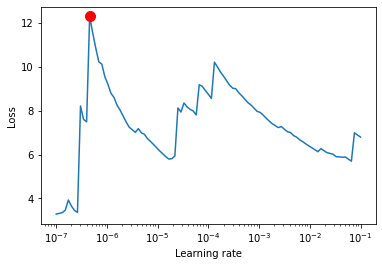

In [16]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [17]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10, verbose=False, mode='min')

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lighting_logs')

trainer = pl.Trainer(
    max_epochs=30,
    weights_summary='top',
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=5e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 19.373000k


In [18]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [19]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [20]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

val_predictions = best_tft.predict(val_dataloader)

In [22]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals, val_predictions))

tensor(7.2009)

In [23]:
!pwd

/Users/maverick/Desktop/Development Projects/ML/TimeSeriesForecasting


In [24]:
df_test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
df_test = df_test.drop(['ID'], axis=1)
df_test['date_block_num']=34
df_test['item_cnt_mnth']=0

pred, x = best_tft.predict(df_test, return_x=True)



<IPython.core.display.Javascript object>

In [25]:
df_test

,shop_id,item_id,date_block_num,item_cnt_mnth
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0
3,5,5232,34,0
4,5,5268,34,0
...,...,...,...,...
214195,45,18454,34,0
214196,45,16188,34,0
214197,45,15757,34,0
214198,45,19648,34,0
